# Upload dataset kaggle dataset to huggingface 

If the specific Hugging Face dataset with the name `stanpony/european_credit_card_dataset` doesn't exist, we upload the CSV from the Kaggle dataset to Hugging Face. Otherwise, we create it.

In [55]:
from datasets import Dataset, DatasetDict, load_dataset
import os
from dotenv import load_dotenv
from huggingface_hub import login

# Load the Hugging Face API token from the .env file
load_dotenv()
hf_api_token = os.getenv('HF_API_TOKEN')

# Log in to Hugging Face
login(token=hf_api_token)

dataset_name = "stanpony/european_credit_card_fraud_dataset"
try:
    # Check if the dataset exists by trying to load the train split
    train_dataset = load_dataset(dataset_name, split='train')
    vali_dataset = load_dataset(dataset_name, split='validation')
    print(f"Dataset {dataset_name} already exists.")
    print("Loaded train and validation splits.")
except:
    import pandas as pd
    from sklearn.model_selection import train_test_split

    # Load the CSV file into a DataFrame
    df = pd.read_csv("data/creditcard.csv")

    # Remove duplicate rows
    df.drop_duplicates(inplace=True)

    # Select all rows where Class == 1 (fraud cases)
    df_class_1 = df[df['Class'] == 1].copy()
    df_class_1['original_index'] = df_class_1.index

    # Select 15,000 random rows where Class == 0 (non-fraud cases)
    df_class_0 = df[df['Class'] == 0].sample(n=15000, random_state=42).copy()
    df_class_0['original_index'] = df_class_0.index

    # Reorder columns to make 'original_index' the first column
    df_class_1 = df_class_1[['original_index'] + [col for col in df_class_1.columns if col != 'original_index']]
    df_class_0 = df_class_0[['original_index'] + [col for col in df_class_0.columns if col != 'original_index']]

    # Combine the two dataframes
    new_df = pd.concat([df_class_1, df_class_0]).reset_index(drop=True)

    # Split the dataframe into train and a temporary set (33% of the data), stratifying by 'Class'
    train_df, temp_df = train_test_split(new_df, test_size=0.2, stratify=new_df['Class'], random_state=42)

    # Further split the temporary set into test and validation sets:
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Class'], random_state=42)

    # Save the train, test, and validation sets to CSV files
    train_df.to_csv('data/train_creditcard.csv', index=False)
    test_df.to_csv('data/test_creditcard.csv', index=False)
    val_df.to_csv('data/val_creditcard.csv', index=False)

    # Create a dictionary mapping split names to file paths
    data_files = {
        "train": "data/train_creditcard.csv",
        "test": "data/test_creditcard.csv",
        "validation": "data/val_creditcard.csv"
    }

    # Create a DatasetDict with train, test, and validation splits
    dataset = DatasetDict({
        "train": Dataset.from_csv(data_files["train"]),
        "test": Dataset.from_csv(data_files["test"]),
        "validation": Dataset.from_csv(data_files["validation"])
    })

    # Push the dataset to Hugging Face Hub
    dataset.push_to_hub(dataset_name)
    print(f"Dataset {dataset_name} created and uploaded.")

    # Load the train dataset from the Hub for verification
    train_dataset = load_dataset(dataset_name, split='train')
    print(f"Dataset train loaded.")
    vali_dataset = load_dataset(dataset_name, split='validation')
    print(f"Dataset validation loaded.")


Dataset stanpony/european_credit_card_fraud_dataset already exists.
Loaded train and validation splits.


# Train VAE (latent feature extractor)

## Train Fraud VAE

In [ ]:
# Minimal example for training VAE with your existing config file

# Imports
from dataloader import load_fraud_data, load_config
from model_VAE import VariationalAutoEncoder
from trainer import Trainer

# Path to config file
CONFIG_PATH = 'configs/fraud_vae/vae_test.config'

try:
    # 1. Load configuration and data
    config = load_config(CONFIG_PATH)
    data = load_fraud_data(config_path=CONFIG_PATH)

    # 2. Create model from VAE section of config
    model = VariationalAutoEncoder(config['VAE'])

    # 3. Explicitly disable wandb if you don't want to use it
    if 'WandB' not in config:
        config['WandB'] = {}
    config['WandB']['use_wandb'] = False  # Set to True if you want to use wandb

    # 4. Create trainer and train
    trainer = Trainer(model=model, dataloaders=data['dataloaders'], config=config)
    history = trainer.train()

    # 5. Evaluate on test set
    test_metrics = trainer.evaluate_on_test()
    print("\nTest metrics:")
    for name, value in test_metrics.items():
        print(f"{name}: {value:.6f}")

except Exception as e:
    # If any error occurs, make sure to clean up wandb
    print(f"An error occurred: {e}")
    if 'trainer' in locals():
        trainer.cleanup_wandb()
    raise e

finally:
    # Always ensure wandb is properly closed
    if 'trainer' in locals():
        trainer.cleanup_wandb()
    print("\nTraining complete!")

/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded configuration from configs/fraud_vae/vae_test.config


2025-03-05 16:17:10,144 [INFO] Using device: cpu


Filtered dataset to class 1: 378 samples
Normalization statistics (calculated from class 1): {'Time': {'mean': 80790.48148148147, 'std': 48332.5139872635}, 'Amount': {'mean': 133.6764814814815, 'std': 276.3532237447719}}
Filtered dataset to class 1: 378 samples
Filtered dataset to class 1: 47 samples
Filtered dataset to class 1: 48 samples


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/alexkstern/.netrc
wandb: Currently logged in as: alexkstern (alexksternteam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


2025-03-05 16:17:17,804 [INFO] WandB initialized: project=fraud-vae, run=vae-fraud-training
2025-03-05 16:17:17,809 [INFO] Starting training
Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 28.77it/s, val_loss=959]
2025-03-05 16:17:18,791 [INFO] Saved checkpoint to saved_models/fraud/v1/VariationalAutoEncoder_fraud_20250305-161711_epoch1_val419.7570.pt
2025-03-05 16:17:19,039 [INFO] Epoch 1/50 - Time: 1.23s
2025-03-05 16:17:19,042 [INFO]   Train Loss: 458.753124 (Recon: 453.634746, KL: 5.118378)
2025-03-05 16:17:19,044 [INFO]   Val Loss: 419.757005 (Recon: 404.048797, KL: 15.708206)
Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 27.60it/s, val_loss=727]
2025-03-05 16:17:20,024 [INFO] Saved checkpoint to saved_models/fraud/v1/VariationalAutoEncoder_fraud_20250305-161711_epoch2_val292.4472.pt
2025-03-05 16:17:20,224 [INFO] Epoch 2/50 - Time: 1.18s
2025-03-05 16:17:20,228 [INFO]   Train Loss: 225.687722 (Recon: 216.650211, KL: 9.037511)
2025-03-05 16:17:20,231 [INFO]   Val Loss:

train/kl_loss,▁▃▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇████████████
train/loss,█▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/recon_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/kl_loss,▄▁▂▃▄▄▅▃▅▆▇▆▇▇▅▆█▅▅▄▅▅▇▆▅▆▇▇▇▇▇▆▆▅▆█▄▆▆▅
val/loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂
val/recon_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▂▂▁▂
train/kl_loss,16.6289
train/loss,97.43638
train/recon_loss,80.80749
val/kl_loss,16.789
val/loss,87.27973


Testing: 100%|██████████| 6/6 [00:00<00:00, 29.83it/s]

test/loss: 65.655947
test/recon_loss: 52.048761
test/kl_loss: 13.607186


## Train Non-Fraud VAE

In [ ]:
# Minimal example for training VAE with your existing config file

# Imports
from dataloader import load_fraud_data, load_config
from model_VAE import VariationalAutoEncoder
from trainer import Trainer

# Path to config file
CONFIG_PATH = 'configs/non_fraud_vae/vae_test.config'

try:
    # 1. Load configuration and data
    config = load_config(CONFIG_PATH)
    data = load_fraud_data(config_path=CONFIG_PATH)

    # 2. Create model from VAE section of config
    model = VariationalAutoEncoder(config['VAE'])

    # 3. Explicitly disable wandb if you don't want to use it
    if 'WandB' not in config:
        config['WandB'] = {}
    config['WandB']['use_wandb'] = False  # Set to True if you want to use wandb

    # 4. Create trainer and train
    trainer = Trainer(model=model, dataloaders=data['dataloaders'], config=config)
    history = trainer.train()

    # 5. Evaluate on test set
    test_metrics = trainer.evaluate_on_test()
    print("\nTest metrics:")
    for name, value in test_metrics.items():
        print(f"{name}: {value:.6f}")

except Exception as e:
    # If any error occurs, make sure to clean up wandb
    print(f"An error occurred: {e}")
    if 'trainer' in locals():
        trainer.cleanup_wandb()
    raise e

finally:
    # Always ensure wandb is properly closed
    if 'trainer' in locals():
        trainer.cleanup_wandb()
    print("\nTraining complete!")

/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded configuration from configs/non_fraud_vae/vae_test.config


Filter: 100%|██████████| 12378/12378 [00:00<00:00, 22188.85 examples/s]


Filtered dataset to class 0: 12000 samples
Normalization statistics (calculated from class 0): {'Time': {'mean': 94364.65358333333, 'std': 47365.815157589255}, 'Amount': {'mean': 87.60478666666666, 'std': 240.59403081682598}}


Filter: 100%|██████████| 12378/12378 [00:00<00:00, 22458.19 examples/s]


Filtered dataset to class 0: 12000 samples


Filter: 100%|██████████| 1547/1547 [00:00<00:00, 12679.26 examples/s]


Filtered dataset to class 0: 1500 samples


Filter: 100%|██████████| 1548/1548 [00:00<00:00, 13912.50 examples/s]
2025-03-05 16:33:23,255 [INFO] Using device: cpu


Filtered dataset to class 0: 1500 samples


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/alexkstern/.netrc
wandb: Currently logged in as: alexkstern (alexksternteam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


2025-03-05 16:33:30,742 [INFO] WandB initialized: project=non-fraud-vae, run=vae-fraud-training
2025-03-05 16:33:30,745 [INFO] Starting training
Epoch 1/50 [Val]: 100%|██████████| 47/47 [00:00<00:00, 89.69it/s, val_loss=21]   
2025-03-05 16:33:35,936 [INFO] Saved checkpoint to saved_models/non_fraud/v1/VariationalAutoEncoder_non-fraud_20250305-163324_epoch1_val21.2505.pt
2025-03-05 16:33:36,179 [INFO] Epoch 1/50 - Time: 5.43s
2025-03-05 16:33:36,182 [INFO]   Train Loss: 25.413530 (Recon: 20.682736, KL: 4.730794)
2025-03-05 16:33:36,185 [INFO]   Val Loss: 21.250500 (Recon: 14.804658, KL: 6.445842)
Epoch 2/50 [Val]: 100%|██████████| 47/47 [00:00<00:00, 83.15it/s, val_loss=19.5] 
2025-03-05 16:33:41,455 [INFO] Saved checkpoint to saved_models/non_fraud/v1/VariationalAutoEncoder_non-fraud_20250305-163324_epoch2_val20.2577.pt
2025-03-05 16:33:41,638 [INFO] Epoch 2/50 - Time: 5.45s
2025-03-05 16:33:41,640 [INFO]   Train Loss: 21.398632 (Recon: 15.004497, KL: 6.394135)
2025-03-05 16:33:41,641

train/kl_loss,▁▆▇█████
train/loss,█▄▃▂▂▂▁▁
train/recon_loss,█▄▃▂▂▁▁▁
val/kl_loss,▁▃▂▆▆▅█▇
val/loss,█▆▃▂▂▁▂▂
val/recon_loss,█▆▃▂▂▁▁▁
train/kl_loss,6.91507
train/loss,18.74769
train/recon_loss,11.83262
val/kl_loss,7.61146
val/loss,18.47719


Testing:   2%|▏         | 1/47 [00:00<00:14,  3.19it/s]


AttributeError: 'NoneType' object has no attribute '_log'

## Build classifier with trained latent Feature

In [8]:
# Simple script to load VAE dataset without the original data

import numpy as np
import pandas as pd
import os

# Directory with the VAE dataset
data_dir = 'vae_dataset'

# Select which split to visualize
split = 'train'  # Options: 'train', 'val', 'test'

# Load the data
print(f"Loading {split} dataset...")
X = np.load(os.path.join(data_dir, f'{split}_combined_features.npy'))
feature_names = np.load(os.path.join(data_dir, f'{split}_feature_names.npy'), allow_pickle=True)
labels = np.load(os.path.join(data_dir, f'{split}_labels.npy'))

# Create DataFrame with feature names
df = pd.DataFrame(X, columns=feature_names)

# Add label column
df['label'] = labels

# Display basic information
print(f"DataFrame shape: {df.shape}")

# Display the head of the DataFrame
df.head()

Loading train dataset...
DataFrame shape: (12378, 23)


,fraud_latent_0,fraud_latent_1,fraud_latent_2,fraud_latent_3,fraud_latent_4,fraud_latent_5,fraud_latent_6,fraud_latent_7,fraud_latent_8,fraud_latent_9,...,non_fraud_latent_2,non_fraud_latent_3,non_fraud_latent_4,non_fraud_latent_5,non_fraud_latent_6,non_fraud_latent_7,non_fraud_latent_8,non_fraud_latent_9,non_fraud_recon_error,label
0,-0.615643,0.751735,-0.404673,0.545401,-0.288656,-0.766497,0.099406,2.070422,0.142465,-0.773488,...,0.169732,-0.540064,0.177553,-0.771990,-1.690295,-1.534132,-2.203338,0.374561,0.354833,0
1,-1.250439,0.235100,0.025312,-0.269650,-0.987701,-0.920562,-0.994900,1.402146,-0.038242,0.495690,...,-0.518433,-0.979053,1.128486,-0.038908,0.519204,0.301190,0.725730,-0.704731,0.105169,0
2,-1.041233,1.005673,-0.295047,-0.495441,-0.633346,-0.538213,-0.912619,1.734814,0.155106,-0.067113,...,-0.645789,1.043757,-0.616265,0.510356,-0.252283,-0.158109,-0.577012,0.256973,0.280511,0
3,-1.411137,0.593400,-0.428755,0.556435,-0.720047,-0.651324,-0.310020,2.148195,-0.593145,-0.470835,...,-0.988748,-0.495142,0.539933,-0.649971,0.252956,1.011837,-0.883104,1.754187,0.570871,0
4,-0.627044,0.368182,-0.246027,-0.848488,-0.669438,-0.823566,-0.687639,2.041727,0.406208,-0.008551,...,0.859374,0.759472,-0.138708,0.008946,-0.660882,-1.112314,-0.496360,-0.240784,0.230561,0


Loading train dataset...
Loading test dataset...
Train VAE features shape: (12378, 22)
Train original features shape: (12378, 30)
Train labels shape: (12378,)
Test VAE features shape: (1548, 22)
Test original features shape: (1548, 30)
Test labels shape: (1548,)

Training MLP on VAE features...


/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training completed in 18.07 seconds

Training MLP on original features...
Training completed in 2.61 seconds

Evaluating MLP with VAE features on test set...
Accuracy (VAE features): 0.9432
ROC AUC (VAE features): 0.2749
Classification Report (VAE features):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1500
           1       0.10      0.10      0.10        48

    accuracy                           0.94      1548
   macro avg       0.54      0.54      0.54      1548
weighted avg       0.94      0.94      0.94      1548


Evaluating MLP with original features on test set...
Accuracy (original features): 0.9690
ROC AUC (original features): 0.6034
Classification Report (original features):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1500
           1       0.00      0.00      0.00        48

    accuracy                           0.97      1548
   macro avg       0.48   

/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

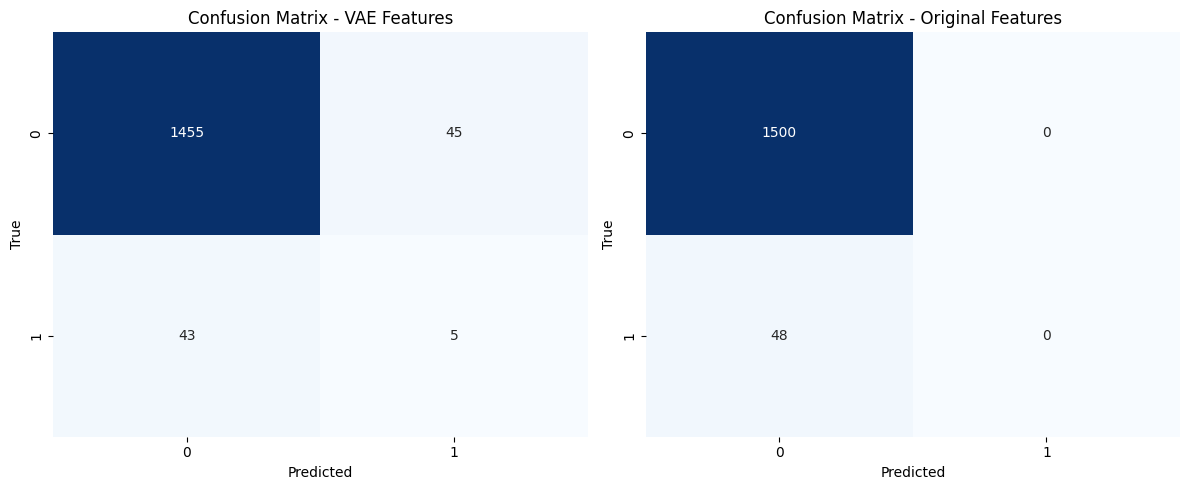

In [10]:
# MLP Classifier Comparison: VAE Features vs Original Features

import numpy as np
import pandas as pd
import os
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Directory with the VAE dataset
data_dir = 'vae_dataset'

# Load train data
print("Loading train dataset...")
X_train_vae = np.load(os.path.join(data_dir, 'train_combined_features.npy'))
feature_names = np.load(os.path.join(data_dir, 'train_feature_names.npy'), allow_pickle=True)
y_train = np.load(os.path.join(data_dir, 'train_labels.npy'))
X_train_original = np.load(os.path.join(data_dir, 'train_original_data.npy'))

# Load test data
print("Loading test dataset...")
X_test_vae = np.load(os.path.join(data_dir, 'test_combined_features.npy'))
y_test = np.load(os.path.join(data_dir, 'test_labels.npy'))
X_test_original = np.load(os.path.join(data_dir, 'test_original_data.npy'))

# Print dataset shapes
print(f"Train VAE features shape: {X_train_vae.shape}")
print(f"Train original features shape: {X_train_original.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test VAE features shape: {X_test_vae.shape}")
print(f"Test original features shape: {X_test_original.shape}")
print(f"Test labels shape: {y_test.shape}")

# Create and train MLP on VAE features
print("\nTraining MLP on VAE features...")
start_time = time()
mlp_vae = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=200,
    random_state=42
)
mlp_vae.fit(X_train_vae, y_train)
vae_training_time = time() - start_time
print(f"Training completed in {vae_training_time:.2f} seconds")

# Create and train MLP on original features
print("\nTraining MLP on original features...")
start_time = time()
mlp_original = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=200,
    random_state=42
)
mlp_original.fit(X_train_original, y_train)
original_training_time = time() - start_time
print(f"Training completed in {original_training_time:.2f} seconds")

# Evaluate on test set - VAE features
print("\nEvaluating MLP with VAE features on test set...")
y_pred_vae = mlp_vae.predict(X_test_vae)
y_pred_proba_vae = mlp_vae.predict_proba(X_test_vae)[:, 1]

accuracy_vae = accuracy_score(y_test, y_pred_vae)
roc_auc_vae = roc_auc_score(y_test, y_pred_proba_vae)
report_vae = classification_report(y_test, y_pred_vae)

print(f"Accuracy (VAE features): {accuracy_vae:.4f}")
print(f"ROC AUC (VAE features): {roc_auc_vae:.4f}")
print("Classification Report (VAE features):")
print(report_vae)

# Evaluate on test set - Original features
print("\nEvaluating MLP with original features on test set...")
y_pred_original = mlp_original.predict(X_test_original)
y_pred_proba_original = mlp_original.predict_proba(X_test_original)[:, 1]

accuracy_original = accuracy_score(y_test, y_pred_original)
roc_auc_original = roc_auc_score(y_test, y_pred_proba_original)
report_original = classification_report(y_test, y_pred_original)

print(f"Accuracy (original features): {accuracy_original:.4f}")
print(f"ROC AUC (original features): {roc_auc_original:.4f}")
print("Classification Report (original features):")
print(report_original)

# Compare results
print("\n=== Performance Comparison ===")
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC AUC', 'Training Time (s)'],
    'VAE Features': [accuracy_vae, roc_auc_vae, vae_training_time],
    'Original Features': [accuracy_original, roc_auc_original, original_training_time]
})
print(comparison)

# Create confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_vae = confusion_matrix(y_test, y_pred_vae)
sns.heatmap(cm_vae, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - VAE Features')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
cm_original = confusion_matrix(y_test, y_pred_original)
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Original Features')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Build with normal features, plus only the reconstruction error

In [1]:
#!/usr/bin/env python
# Script to load VAE dataset training and validation sets

import numpy as np
import pandas as pd
import os

# Get current working directory and parent directory
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)

print(f"Current working directory: {cwd}")
print(f"Parent directory: {parent_dir}")

# Directory with the VAE dataset - look in current directory first
data_dir = os.path.join(cwd, 'vae_dataset')
print(f"Looking for dataset in: {data_dir}")

# Check if the dataset exists in the current directory
if not os.path.exists(os.path.join(data_dir, 'train_combined_features.npy')):
    # If not, try the parent directory
    data_dir = os.path.join(parent_dir, 'vae_dataset')
    print(f"Dataset not found in current directory, trying: {data_dir}")

# Function to load a specific split
def load_split(split_name):
    print(f"Loading {split_name} dataset...")
    try:
        # Load the combined features (original features + reconstruction errors)
        X = np.load(os.path.join(data_dir, f'{split_name}_combined_features.npy'))
        feature_names = np.load(os.path.join(data_dir, f'{split_name}_feature_names.npy'), allow_pickle=True)
        labels = np.load(os.path.join(data_dir, f'{split_name}_labels.npy'))
        
        print(f"Successfully loaded {split_name} dataset from {data_dir}")
        
        # Create DataFrame with feature names
        df = pd.DataFrame(X, columns=feature_names)
        
        # Add label column
        df['label'] = labels
        
        return df
        
    except FileNotFoundError as e:
        print(f"Error loading {split_name} dataset: {e}")
        print(f"Please check that the VAE dataset has been created in the correct location.")
        print(f"Expected files:")
        print(f"  - {os.path.join(data_dir, f'{split_name}_combined_features.npy')}")
        print(f"  - {os.path.join(data_dir, f'{split_name}_feature_names.npy')}")
        print(f"  - {os.path.join(data_dir, f'{split_name}_labels.npy')}")
        return None

# Load training and validation datasets
df_train = load_split('train')
df_val = load_split('val')

# Print basic information
if df_train is not None:
    print(f"Training set shape: {df_train.shape}")
    
if df_val is not None:
    print(f"Validation set shape: {df_val.shape}")

Current working directory: /home/alexkstern/fraudml/latent_classifier
Parent directory: /home/alexkstern/fraudml
Looking for dataset in: /home/alexkstern/fraudml/latent_classifier/vae_dataset
Loading train dataset...
Successfully loaded train dataset from /home/alexkstern/fraudml/latent_classifier/vae_dataset
Loading val dataset...
Successfully loaded val dataset from /home/alexkstern/fraudml/latent_classifier/vae_dataset
Training set shape: (12378, 33)
Validation set shape: (1547, 33)


In [2]:
df_train

,original_0,original_1,original_2,original_3,original_4,original_5,original_6,original_7,original_8,original_9,...,original_23,original_24,original_25,original_26,original_27,original_28,original_29,fraud_recon_error,non_fraud_recon_error,label
0,145368.0,-0.415096,-1.100460,-0.682283,-3.727771,-0.264645,-0.905293,1.900959,-0.614940,-0.168312,...,0.334153,-0.538651,0.050439,-0.809344,-0.051146,-0.031781,290.95,0.224054,0.089201,0
1,67293.0,-2.136455,2.214158,-0.080440,-0.667330,0.359749,0.523744,0.027583,-0.273849,0.513318,...,0.078767,-1.250631,0.162055,0.150119,0.398673,0.119816,8.92,0.780987,0.143534,0
2,55801.0,-0.366200,-0.519146,1.588975,-1.879137,-0.704906,0.025870,0.327650,-0.174074,0.014051,...,0.006228,-0.298541,-0.019685,-0.597609,0.030729,-0.085559,105.30,0.651506,0.170724,0
3,125977.0,-2.108190,1.477962,-0.441905,-0.057876,1.908325,4.435993,-0.775634,2.085837,0.015895,...,0.098717,0.623443,0.599187,-0.753901,0.245272,0.112804,11.90,0.693144,0.125959,0
4,34996.0,-0.655565,-0.302250,0.695606,-2.010890,0.555060,-0.564264,-0.085176,0.159812,-1.197654,...,-0.224064,-0.860353,0.037801,-0.262891,0.321288,0.186786,17.90,1.364019,0.106135,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12373,88487.0,2.048291,0.095118,-1.712217,0.426276,0.391722,-0.816390,0.155407,-0.191763,0.550127,...,0.346979,0.498078,-0.292815,0.175770,-0.063648,-0.030194,9.99,1.027689,0.521781,0
12374,123003.0,1.922704,-0.189449,-0.853484,0.631061,-0.655126,-1.769673,0.204265,-0.298528,0.842122,...,0.418435,0.782394,-0.352520,-0.653211,-0.028091,-0.039004,34.15,0.657560,0.136288,0
12375,165738.0,2.302149,-0.636068,-1.747061,-1.168425,0.066820,-0.526117,-0.372733,-0.293468,-0.572581,...,-0.052596,0.098216,0.323819,0.080988,-0.035999,-0.067419,1.00,1.260344,0.216465,0
12376,73126.0,0.952403,-0.888648,0.930229,-1.025187,-1.643450,-1.143576,-0.381096,-0.197165,1.710055,...,-0.181840,1.045131,0.401031,0.061365,0.026231,0.056853,150.00,0.261476,0.261997,0


In [3]:
df_val

,original_0,original_1,original_2,original_3,original_4,original_5,original_6,original_7,original_8,original_9,...,original_23,original_24,original_25,original_26,original_27,original_28,original_29,fraud_recon_error,non_fraud_recon_error,label
0,1358.0,-2.029822,1.866869,0.604924,-1.310795,0.571774,0.386385,0.331670,-1.694331,0.752595,...,0.066733,-0.827689,0.184810,0.341179,0.543111,0.173462,5.00,0.694593,0.358948,0
1,69731.0,-1.099359,0.485656,1.960178,-0.856214,-0.370435,-0.045546,0.113500,0.166708,1.051843,...,-0.060273,0.057338,-0.340332,-0.056713,-0.487970,0.053277,24.90,0.474397,0.278449,0
2,65392.0,1.335494,-0.642265,-0.021790,-0.952839,-0.194245,0.576060,-0.598118,0.089697,-0.958198,...,-0.163818,-1.101319,0.559396,-0.224057,0.023417,-0.001886,42.00,0.603610,0.128794,0
3,145381.0,-0.693074,0.557157,1.448831,-0.751572,0.443361,0.152641,0.480894,-0.217649,0.805310,...,-0.275001,0.647856,-0.218889,-0.339965,-0.409657,0.029021,11.50,0.281187,0.150367,0
4,132021.0,1.725635,-0.764049,-1.960949,0.180658,0.242354,-0.684625,0.523553,-0.440580,0.342953,...,-0.287272,-0.895103,0.138922,0.822937,-0.128725,-0.040150,229.00,0.475237,0.181688,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,146208.0,1.623233,-0.656654,-0.654986,0.996206,0.273691,1.614846,-0.652571,0.491694,0.609753,...,0.031278,-1.630759,-0.275910,-0.462479,0.084199,-0.037342,114.65,0.631619,0.226681,0
1543,128204.0,1.268431,-0.806536,0.091157,4.061948,-0.497277,1.227543,-0.395643,0.352939,-0.136795,...,0.094595,-0.528040,-0.581502,-0.321734,-0.025005,0.008085,285.51,0.643537,0.145337,0
1544,67248.0,-0.414037,1.105370,0.814476,0.041337,-0.309812,-0.907809,0.447003,0.369005,-0.979019,...,0.335204,0.476859,-0.731238,-0.265649,-0.122848,-0.029385,19.57,0.375525,0.140605,0
1545,67426.0,-8.121593,6.336662,-2.910658,-2.469968,-3.079614,-1.132036,-1.958246,3.069612,3.321497,...,0.639044,0.144090,0.912086,0.845853,2.036333,1.268598,0.76,4.514094,0.387816,0


## Utils

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    classification_report, 
    confusion_matrix,
    precision_recall_curve
)

def prepare_data(df_train, df_val, target_col, drop_cols=None):
    """
    Prepare training and validation data by splitting features and target.
    
    Parameters:
    -----------
    df_train : pandas.DataFrame
        Training dataframe
    df_val : pandas.DataFrame
        Validation dataframe
    target_col : str
        Name of the target column
    drop_cols : list, optional
        List of columns to drop (excluding target column)
        
    Returns:
    --------
    X_train, y_train, X_val, y_val : tuple of pandas.DataFrame/Series
        Prepared datasets for training and validation
    """
    # Make a copy to avoid modifying the original dataframes
    df_train = df_train.copy()
    df_val = df_val.copy()
    
    # Create list of columns to drop
    cols_to_drop = [target_col]
    if drop_cols:
        cols_to_drop.extend(drop_cols)
    
    # Extract features and target
    y_train = df_train[target_col]
    X_train = df_train.drop(columns=cols_to_drop)
    
    y_val = df_val[target_col]
    X_val = df_val.drop(columns=cols_to_drop)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    
    return X_train, y_train, X_val, y_val

def train_xgboost(X_train, y_train, X_val, y_val, params=None):
    """
    Train an XGBoost model with the given parameters.
    
    Parameters:
    -----------
    X_train : pandas.DataFrame
        Training features
    y_train : pandas.Series
        Training target
    X_val : pandas.DataFrame
        Validation features
    y_val : pandas.Series
        Validation target
    params : dict, optional
        XGBoost parameters dictionary
        
    Returns:
    --------
    model : xgboost.XGBClassifier
        Trained XGBoost model
    """
    # Default parameters if none provided
    if params is None:
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'learning_rate': 0.1,
            'max_depth': 5,
            'min_child_weight': 1,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42
        }
    
    # Initialize and train model
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=True
    )
    
    return model

def evaluate_model(model, X_train, y_train, X_val, y_val, threshold=0.5, scaler=None, is_mlp=False):
    """
    Evaluate the model performance and visualize results.
    
    Parameters:
    -----------
    model : trained model (XGBClassifier or MLPClassifier)
        Trained model
    X_train : pandas.DataFrame
        Training features
    y_train : pandas.Series
        Training target
    X_val : pandas.DataFrame
        Validation features
    y_val : pandas.Series
        Validation target
    threshold : float, optional
        Classification threshold (default: 0.5)
    scaler : sklearn.preprocessing.StandardScaler, optional
        Fitted scaler for MLP models
    is_mlp : bool, optional
        Whether the model is an MLPClassifier
        
    Returns:
    --------
    metrics : dict
        Dictionary containing evaluation metrics
    """
    # Apply scaling if needed for MLP
    X_val_eval = X_val
    if is_mlp and scaler is not None:
        X_val_eval = scaler.transform(X_val)
    elif isinstance(model, xgb.XGBClassifier):
        # For XGBoost, ensure feature columns match exactly
        X_train_cols = list(X_train.columns)
        X_val_cols = list(X_val.columns)
        
        # Check for feature mismatch
        if set(X_train_cols) != set(X_val_cols):
            print("Feature mismatch detected. Using only training features and disabling validation.")
            # Only keep columns that were in the training data
            if set(X_train_cols).issubset(set(X_val_cols)):
                X_val_eval = X_val[X_train_cols].copy()
    
    # Make predictions - disable feature validation for XGBoost
    if isinstance(model, xgb.XGBClassifier):
        y_pred_proba = model.predict_proba(X_val_eval, validate_features=False)[:, 1]
    else:
        y_val_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val_eval)[:, 1]
        
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    auc = roc_auc_score(y_val, y_pred_proba)
    avg_precision = average_precision_score(y_val, y_pred_proba)
    
    # Print metrics
    print("\n----- Model Evaluation -----")
    print(f"Validation AUC: {auc:.4f}")
    print(f"Validation Average Precision: {avg_precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # For XGBoost models only, show feature importance
    if not is_mlp and hasattr(model, 'feature_importances_'):
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        xgb.plot_importance(model, max_num_features=20)
        plt.title('Top 20 Most Important Features')
        plt.tight_layout()
        plt.show()
        
        # Print top features
        importance = model.feature_importances_
        feature_names = X_train.columns
        feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)
        
        print("\nTop 10 Most Important Features:")
        for feature, importance in feature_importance[:10]:
            print(f"{feature}: {importance:.4f}")
    else:
        # For MLPs, we don't have built-in feature importance
        feature_importance = None
        print("\nFeature importance not available for MLP models.")
    
    
    # Return metrics dictionary
    metrics = {
        'auc': auc,
        'avg_precision': avg_precision,
        'feature_importance': feature_importance if not is_mlp else None,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    return metrics

def train_mlp(X_train, y_train, X_val=None, y_val=None, params=None, scale_data=True):
    """
    Train a scikit-learn MLP (Multi-Layer Perceptron) classifier.
    
    Parameters:
    -----------
    X_train : pandas.DataFrame
        Training features
    y_train : pandas.Series
        Training target
    X_val : pandas.DataFrame, optional
        Validation features for early stopping
    y_val : pandas.Series, optional
        Validation target for early stopping
    params : dict, optional
        MLP parameters dictionary
    scale_data : bool, optional
        Whether to scale the input features (recommended for neural networks)
        
    Returns:
    --------
    model : sklearn.neural_network.MLPClassifier
        Trained MLP model
    scaler : sklearn.preprocessing.StandardScaler or None
        Fitted scaler if scale_data is True, else None
    """
    # Default parameters if none provided
    if params is None:
        params = {
            'hidden_layer_sizes': (100, 50),
            'activation': 'relu',
            'solver': 'adam',
            'alpha': 0.0001,
            'batch_size': 'auto',
            'learning_rate': 'adaptive',
            'learning_rate_init': 0.001,
            'max_iter': 200,
            'early_stopping': True if X_val is not None else False,
            'validation_fraction': 0.1,
            'random_state': 42
        }
    
    # Scale data if requested
    scaler = None
    X_train_scaled = X_train
    X_val_scaled = X_val
    
    if scale_data:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        if X_val is not None:
            X_val_scaled = scaler.transform(X_val)
    
    # Initialize and train model
    model = MLPClassifier(**params)
    
    # Set up early stopping if requested
    if params.get('early_stopping', False) and X_val is not None:
        # sklearn's MLPClassifier handles early stopping differently
        # It uses a portion of the training data as validation
        # For explicit validation set, we need a different approach
        
        # Save the original validation fraction and enable early stopping
        orig_validation_fraction = params.get('validation_fraction', 0.1)
        params['validation_fraction'] = 0.0  # Don't split training data
        params['early_stopping'] = False     # We'll handle it manually
        
        # Initialize model with updated params
        model = MLPClassifier(**params)
        
        # Track scores for manual early stopping
        best_score = 0
        best_iter = 0
        patience = params.get('n_iter_no_change', 10)
        no_improve_count = 0
        max_epochs = params.get('max_iter', 200)
        
        # Initial fit with partial_fit for one epoch
        classes = np.unique(np.concatenate([y_train, y_val]))
        for epoch in range(max_epochs):
            # Train for one epoch
            model.partial_fit(X_train_scaled, y_train, classes=classes)
            
            # Evaluate on validation set
            val_score = model.score(X_val_scaled, y_val)
            
            print(f"Epoch {epoch+1}/{max_epochs}, Validation score: {val_score:.4f}")
            
            # Check for improvement
            if val_score > best_score:
                best_score = val_score
                best_iter = epoch
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            # Early stopping check
            if no_improve_count >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best score at epoch {best_iter+1}: {best_score:.4f}")
                break
    else:
        # Regular fit without early stopping or with sklearn's built-in early stopping
        model.fit(X_train_scaled, y_train)
    
    print(f"MLP training completed with {model.n_iter_} iterations")
    if hasattr(model, 'best_validation_score_') and model.best_validation_score_ is not None:
        print(f"Best validation score: {model.best_validation_score_:.4f}")
    
    return model, scaler

## With reconstruction labels

In [63]:
X_train, y_train, X_val, y_val = prepare_data(
    df_train, df_val, 'label', drop_cols=None
)



Training data shape: (12378, 32)
Validation data shape: (1547, 32)


In [64]:

model = train_xgboost(X_train, y_train, X_val, y_val)


[0]	validation_0-auc:0.95230	validation_1-auc:0.91942
[1]	validation_0-auc:0.96553	validation_1-auc:0.92472
[2]	validation_0-auc:0.96696	validation_1-auc:0.92412
[3]	validation_0-auc:0.97054	validation_1-auc:0.93018
[4]	validation_0-auc:0.97252	validation_1-auc:0.92735
[5]	validation_0-auc:0.97367	validation_1-auc:0.92699
[6]	validation_0-auc:0.97446	validation_1-auc:0.92498
[7]	validation_0-auc:0.97478	validation_1-auc:0.92472
[8]	validation_0-auc:0.97526	validation_1-auc:0.92421
[9]	validation_0-auc:0.98040	validation_1-auc:0.93489
[10]	validation_0-auc:0.98051	validation_1-auc:0.93602
[11]	validation_0-auc:0.98687	validation_1-auc:0.94657
[12]	validation_0-auc:0.98697	validation_1-auc:0.94596
[13]	validation_0-auc:0.98727	validation_1-auc:0.95155
[14]	validation_0-auc:0.98898	validation_1-auc:0.95458
[15]	validation_0-auc:0.98975	validation_1-auc:0.95809
[16]	validation_0-auc:0.98987	validation_1-auc:0.95949
[17]	validation_0-auc:0.99073	validation_1-auc:0.96234
[18]	validation_0-au


----- Model Evaluation -----
Validation AUC: 0.9754
Validation Average Precision: 0.8753

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1500
           1       0.95      0.83      0.89        47

    accuracy                           0.99      1547
   macro avg       0.97      0.91      0.94      1547
weighted avg       0.99      0.99      0.99      1547



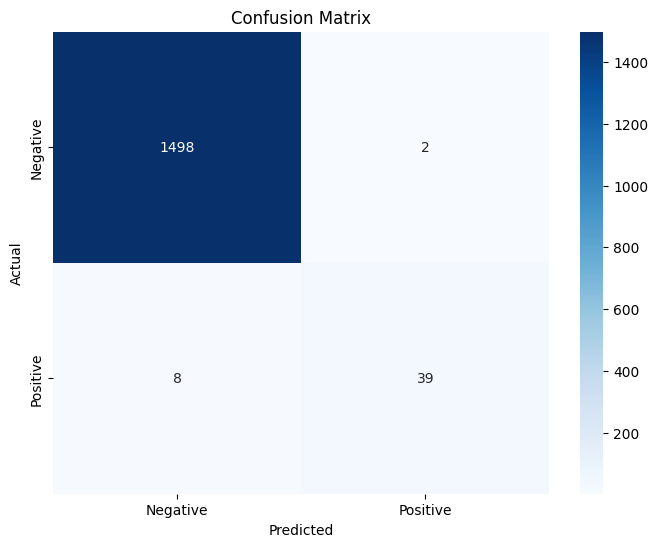

<Figure size 1200x800 with 0 Axes>

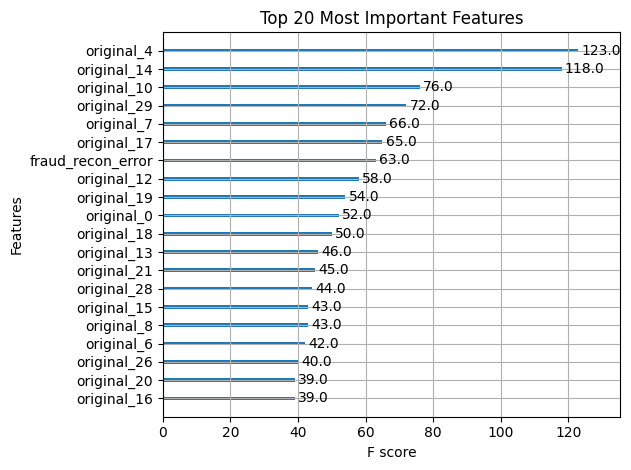


Top 10 Most Important Features:
original_14: 0.3053
original_17: 0.1441
original_10: 0.1329
original_4: 0.0383
original_12: 0.0248
original_16: 0.0185
original_5: 0.0175
original_3: 0.0174
original_29: 0.0159
original_1: 0.0157


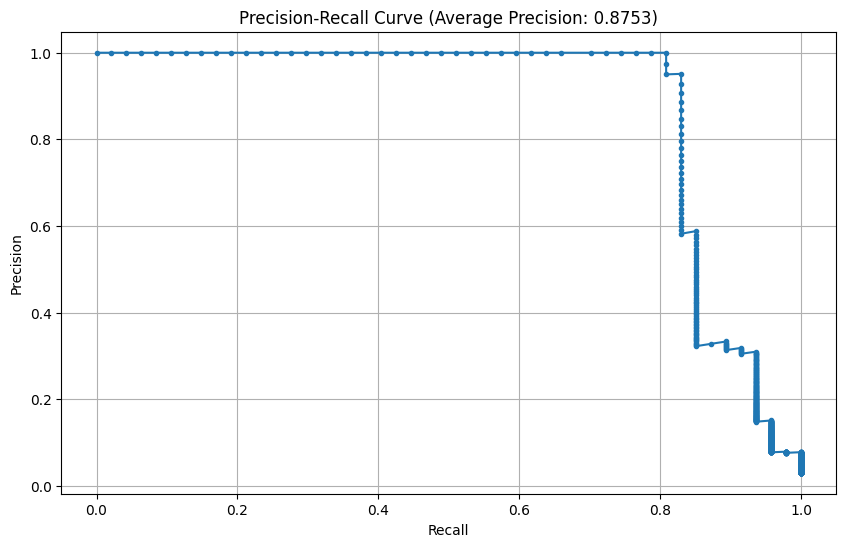

In [65]:
metrics = evaluate_model(model, X_train, y_train, X_val, y_val)

In [67]:
# Custom MLP parameters
mlp_params = {
    'hidden_layer_sizes': (100, 50, 25),  # Three hidden layers
    'activation': 'relu',
    'alpha': 0.001,  # Regularization parameter
    'learning_rate_init': 0.01,
    'max_iter': 300,
    'early_stopping': True,
    'random_state': 42
}

mlp_model, scaler = train_mlp(X_train, y_train, X_val, y_val, params=mlp_params)

Epoch 1/300, Validation score: 0.9922
Epoch 2/300, Validation score: 0.9929
Epoch 3/300, Validation score: 0.9916
Epoch 4/300, Validation score: 0.9935
Epoch 5/300, Validation score: 0.9910
Epoch 6/300, Validation score: 0.9922
Epoch 7/300, Validation score: 0.9922
Epoch 8/300, Validation score: 0.9910
Epoch 9/300, Validation score: 0.9910
Epoch 10/300, Validation score: 0.9935
Epoch 11/300, Validation score: 0.9903
Epoch 12/300, Validation score: 0.9890
Epoch 13/300, Validation score: 0.9916
Epoch 14/300, Validation score: 0.9903
Early stopping at epoch 14. Best score at epoch 4: 0.9935
MLP training completed with 1 iterations


In [70]:
# Perform inference using the trained MLP model
y_val_pred = mlp_model.predict(X_val)
y_val_pred_proba = mlp_model.predict_proba(X_val)[:, 1]

# Print the predicted labels and probabilities
print("Predicted labels:", y_val_pred)
print("Predicted probabilities:", y_val_pred_proba)

Predicted labels: [0 0 0 ... 0 0 0]
Predicted probabilities: [0. 0. 0. ... 0. 0. 0.]


/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(



----- Model Evaluation -----
Validation AUC: 0.9754
Validation Average Precision: 0.8753

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1500
           1       0.95      0.83      0.89        47

    accuracy                           0.99      1547
   macro avg       0.97      0.91      0.94      1547
weighted avg       0.99      0.99      0.99      1547



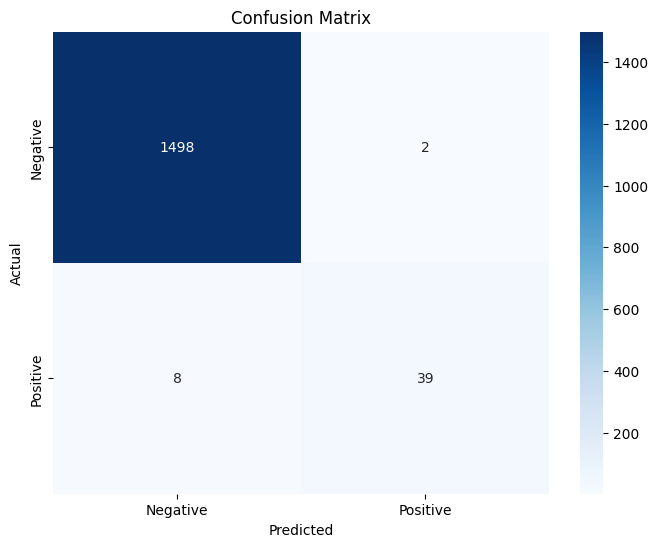

<Figure size 1200x800 with 0 Axes>

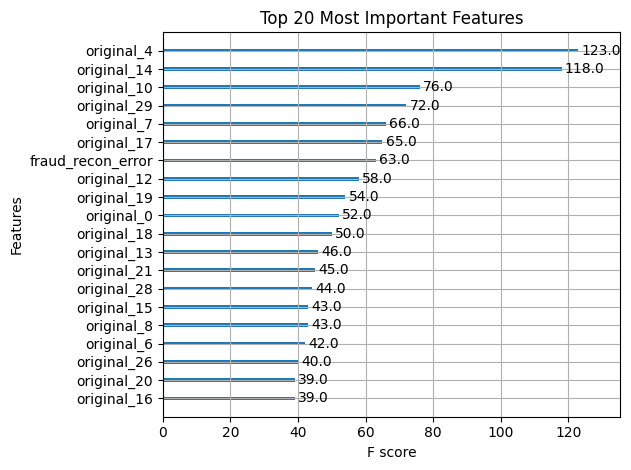


Top 10 Most Important Features:
original_14: 0.3053
original_17: 0.1441
original_10: 0.1329
original_4: 0.0383
original_12: 0.0248
original_16: 0.0185
original_5: 0.0175
original_3: 0.0174
original_29: 0.0159
original_1: 0.0157


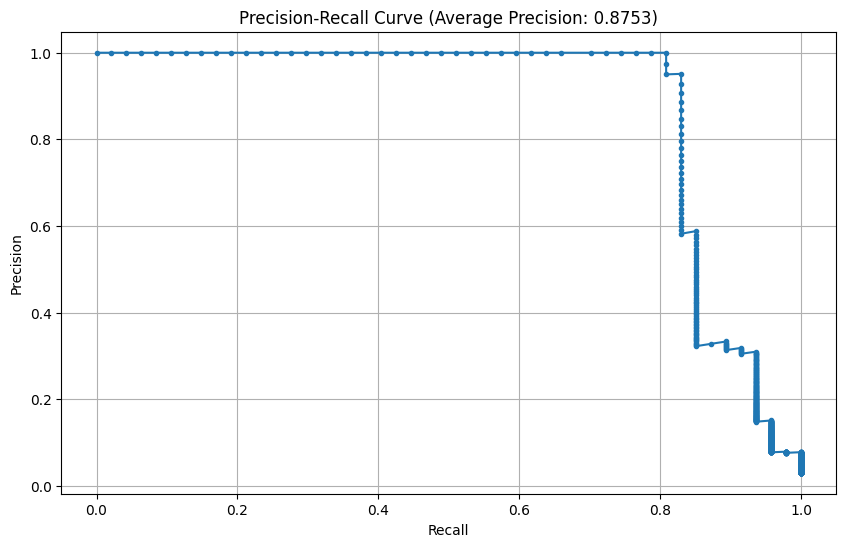

In [72]:
metrics = evaluate_model(model, X_train, y_train, X_val, y_val)


## Without reconstruction (vanilla)

In [41]:
df_train

,original_0,original_1,original_2,original_3,original_4,original_5,original_6,original_7,original_8,original_9,...,original_23,original_24,original_25,original_26,original_27,original_28,original_29,fraud_recon_error,non_fraud_recon_error,label
0,145368.0,-0.415096,-1.100460,-0.682283,-3.727771,-0.264645,-0.905293,1.900959,-0.614940,-0.168312,...,0.334153,-0.538651,0.050439,-0.809344,-0.051146,-0.031781,290.95,0.224054,0.089201,0
1,67293.0,-2.136455,2.214158,-0.080440,-0.667330,0.359749,0.523744,0.027583,-0.273849,0.513318,...,0.078767,-1.250631,0.162055,0.150119,0.398673,0.119816,8.92,0.780987,0.143534,0
2,55801.0,-0.366200,-0.519146,1.588975,-1.879137,-0.704906,0.025870,0.327650,-0.174074,0.014051,...,0.006228,-0.298541,-0.019685,-0.597609,0.030729,-0.085559,105.30,0.651506,0.170724,0
3,125977.0,-2.108190,1.477962,-0.441905,-0.057876,1.908325,4.435993,-0.775634,2.085837,0.015895,...,0.098717,0.623443,0.599187,-0.753901,0.245272,0.112804,11.90,0.693144,0.125959,0
4,34996.0,-0.655565,-0.302250,0.695606,-2.010890,0.555060,-0.564264,-0.085176,0.159812,-1.197654,...,-0.224064,-0.860353,0.037801,-0.262891,0.321288,0.186786,17.90,1.364019,0.106135,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12373,88487.0,2.048291,0.095118,-1.712217,0.426276,0.391722,-0.816390,0.155407,-0.191763,0.550127,...,0.346979,0.498078,-0.292815,0.175770,-0.063648,-0.030194,9.99,1.027689,0.521781,0
12374,123003.0,1.922704,-0.189449,-0.853484,0.631061,-0.655126,-1.769673,0.204265,-0.298528,0.842122,...,0.418435,0.782394,-0.352520,-0.653211,-0.028091,-0.039004,34.15,0.657560,0.136288,0
12375,165738.0,2.302149,-0.636068,-1.747061,-1.168425,0.066820,-0.526117,-0.372733,-0.293468,-0.572581,...,-0.052596,0.098216,0.323819,0.080988,-0.035999,-0.067419,1.00,1.260344,0.216465,0
12376,73126.0,0.952403,-0.888648,0.930229,-1.025187,-1.643450,-1.143576,-0.381096,-0.197165,1.710055,...,-0.181840,1.045131,0.401031,0.061365,0.026231,0.056853,150.00,0.261476,0.261997,0


In [42]:
X_train, y_train, X_val, y_val = prepare_data(
    df_train, df_val, 'label', drop_cols=['fraud_recon_error','non_fraud_recon_error']
)

Training data shape: (12378, 30)
Validation data shape: (1547, 30)


In [43]:

model = train_xgboost(X_train, y_train, X_val, y_val)


[0]	validation_0-auc:0.94430	validation_1-auc:0.90879
[1]	validation_0-auc:0.96208	validation_1-auc:0.92811
[2]	validation_0-auc:0.96401	validation_1-auc:0.92550
[3]	validation_0-auc:0.96489	validation_1-auc:0.92566
[4]	validation_0-auc:0.96502	validation_1-auc:0.92629
[5]	validation_0-auc:0.96597	validation_1-auc:0.92565
[6]	validation_0-auc:0.97607	validation_1-auc:0.94109
[7]	validation_0-auc:0.97857	validation_1-auc:0.93814
[8]	validation_0-auc:0.97873	validation_1-auc:0.93618
[9]	validation_0-auc:0.97997	validation_1-auc:0.93501
[10]	validation_0-auc:0.98025	validation_1-auc:0.93848
[11]	validation_0-auc:0.98532	validation_1-auc:0.95035
[12]	validation_0-auc:0.98552	validation_1-auc:0.95043
[13]	validation_0-auc:0.98675	validation_1-auc:0.95723
[14]	validation_0-auc:0.98743	validation_1-auc:0.95599
[15]	validation_0-auc:0.98873	validation_1-auc:0.95465
[16]	validation_0-auc:0.99023	validation_1-auc:0.95398
[17]	validation_0-auc:0.99076	validation_1-auc:0.95460
[18]	validation_0-au


----- Model Evaluation -----
Validation AUC: 0.9769
Validation Average Precision: 0.8708

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1500
           1       0.97      0.81      0.88        47

    accuracy                           0.99      1547
   macro avg       0.98      0.90      0.94      1547
weighted avg       0.99      0.99      0.99      1547



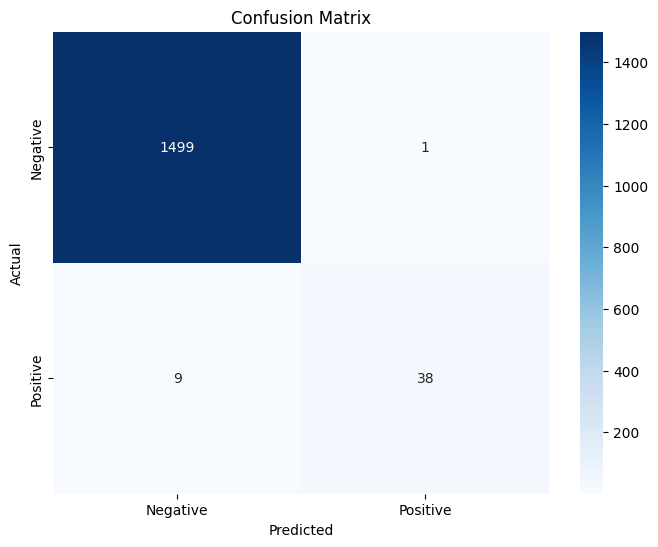

<Figure size 1200x800 with 0 Axes>

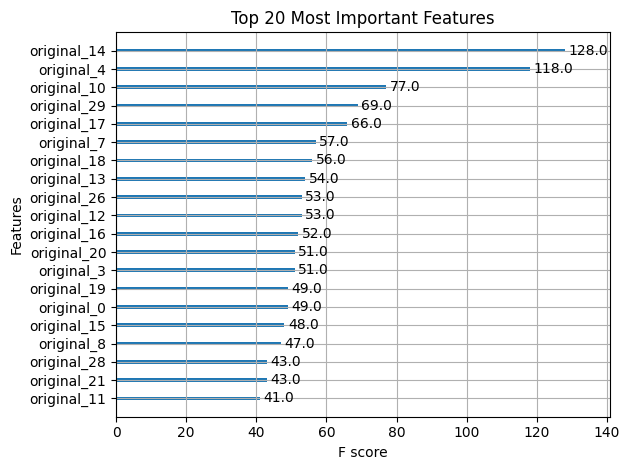


Top 10 Most Important Features:
original_14: 0.3110
original_17: 0.2128
original_12: 0.0484
original_10: 0.0480
original_4: 0.0368
original_11: 0.0194
original_29: 0.0187
original_8: 0.0173
original_6: 0.0159
original_5: 0.0154


In [44]:
metrics = evaluate_model(model, X_train, y_train, X_val, y_val)